In [1]:
import glob
import matplotlib.pyplot as plt
import pickle

import cv2
import numpy as np

from moviepy.editor import VideoFileClip
%matplotlib inline


class CalibSet:
    """A simple Holding class"""
    def __init__(self, objP, imgP):
        self.objectPoints = objP
        self.imagePoints = imgP

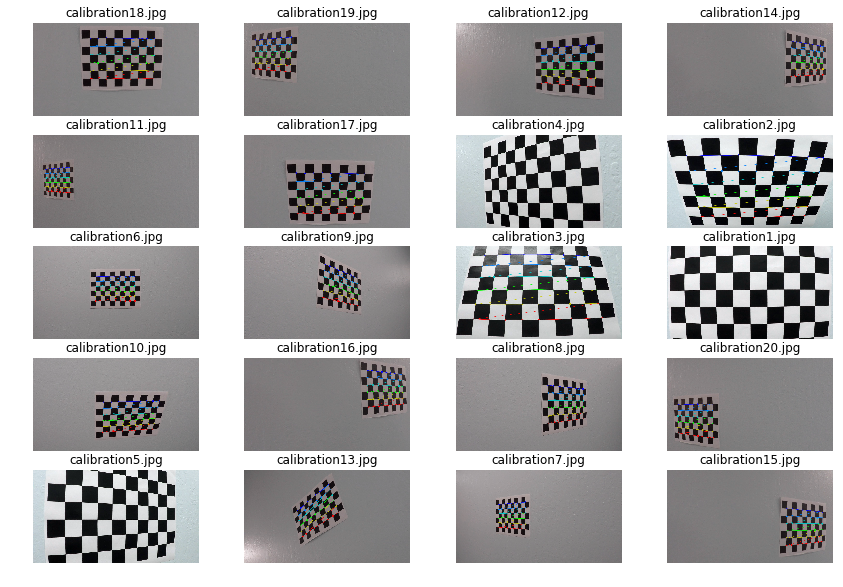

In [2]:
#obj point prep, like in the tutorial
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

calibrationSets = []

# crawl images
images = glob.glob("camera_cal/calibration*.jpg")
#prepare image putput
fig, axis = plt.subplots(5,4)
fig.subplots_adjust(right=2, top=2)
axis = axis.ravel()
# Step through the list and search for chessboard corners
for i, file in enumerate(images):
    #load image and create grayscale
    img = cv2.imread(file)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    meta, corners = cv2.findChessboardCorners(img_gray, (9,6), None)
    axis[i].set_title(file.split("/")[1])
    axis[i].axis('off')
    if meta == True:
        calibrationSets.append(CalibSet(objp, corners))
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, meta)
    axis[i].imshow(img)
        
#print(calibrationPointSets)


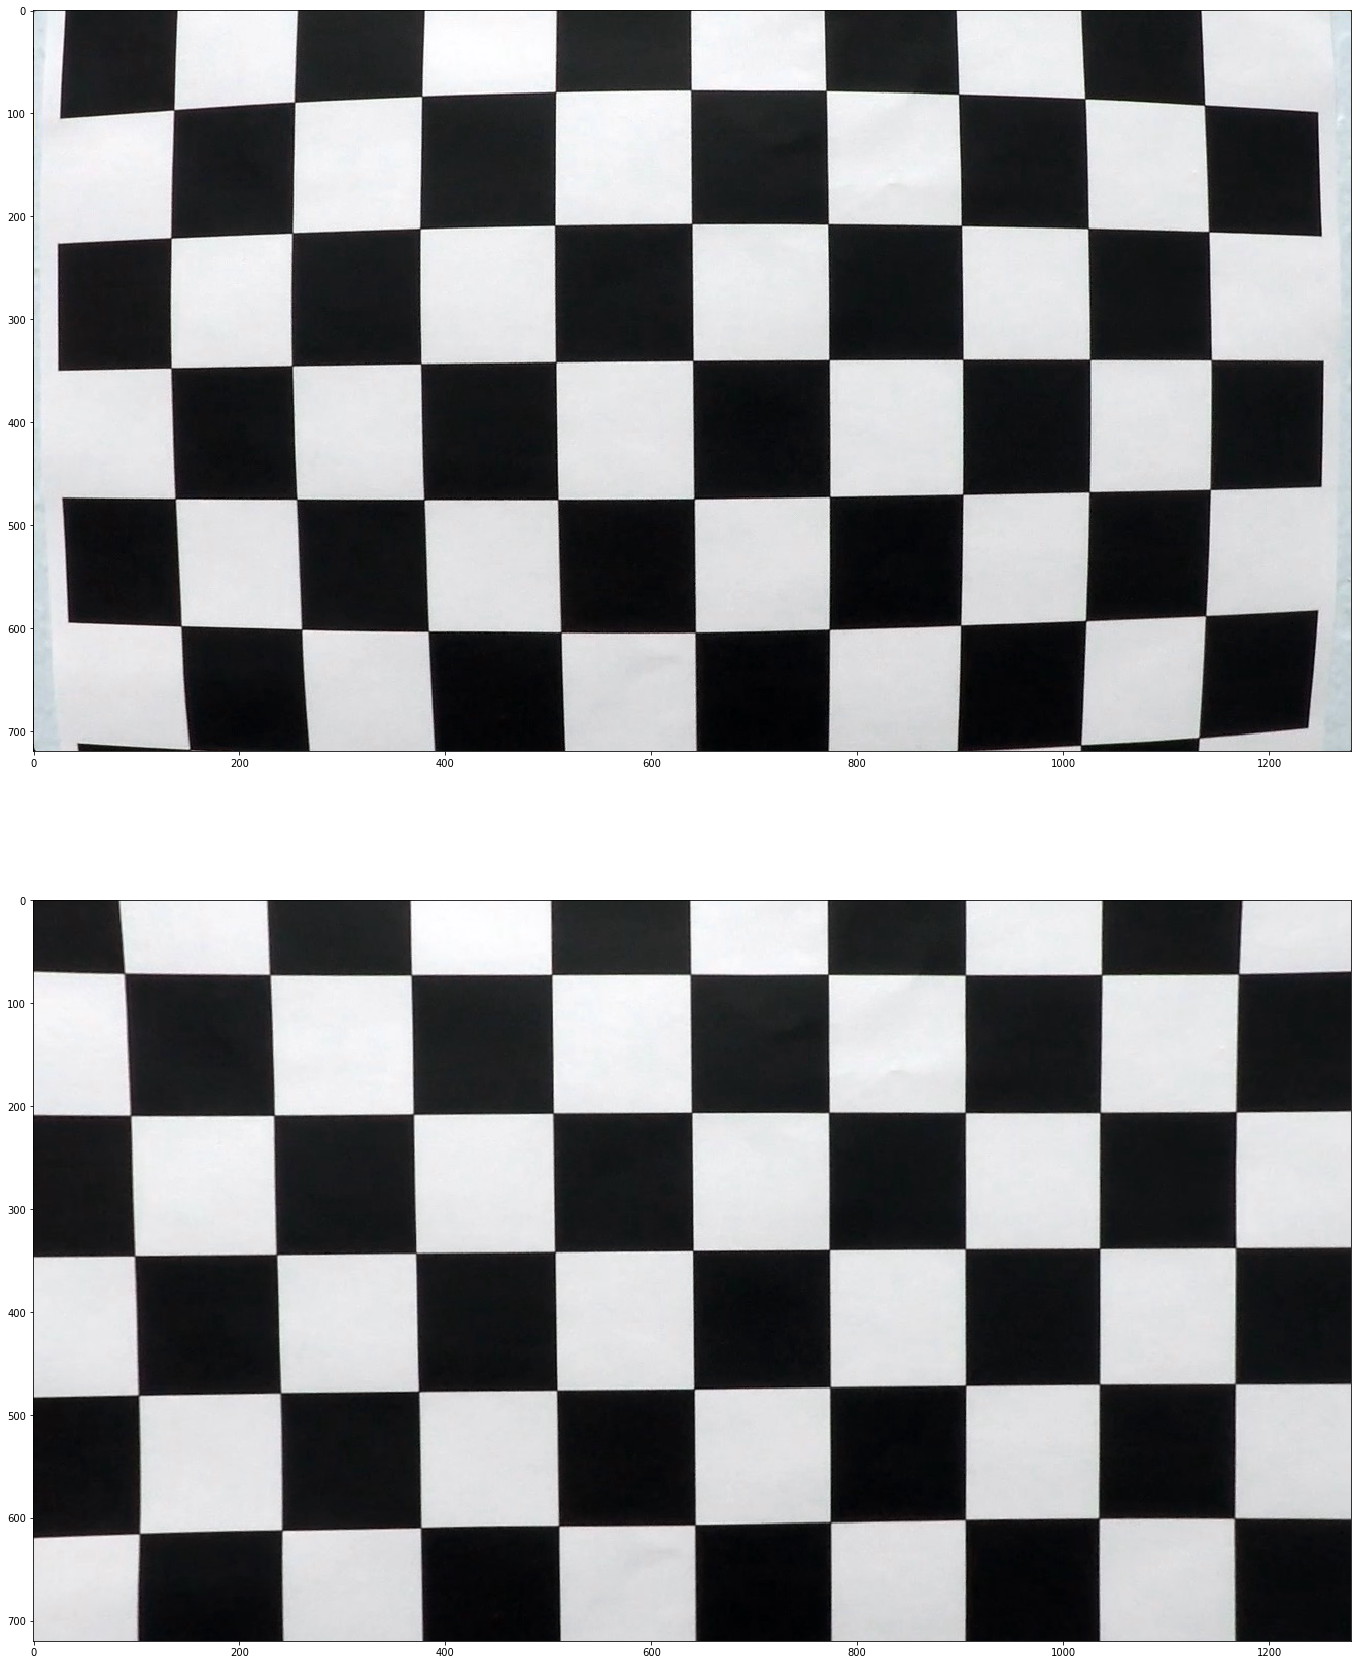

In [3]:
img = cv2.imread("camera_cal/calibration1.jpg")
img_size = (img.shape[1], img.shape[0])
# Do camera calibration given object points and image points
objpoints = [cs.objectPoints for cs in calibrationSets]
imgpoints = [cs.imagePoints for cs in calibrationSets]
meta, matrix, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

# Undistort image
img_undistorted = cv2.undistort(img, matrix, dist, None, matrix)

# Visualize
f, axis = plt.subplots(2,1,figsize=(30,30))
axis = axis.ravel()
axis[0].imshow(img)
axis[1].imshow(img_undistorted)
#safe result image
plt.savefig('./examples/undistortedImage.png')

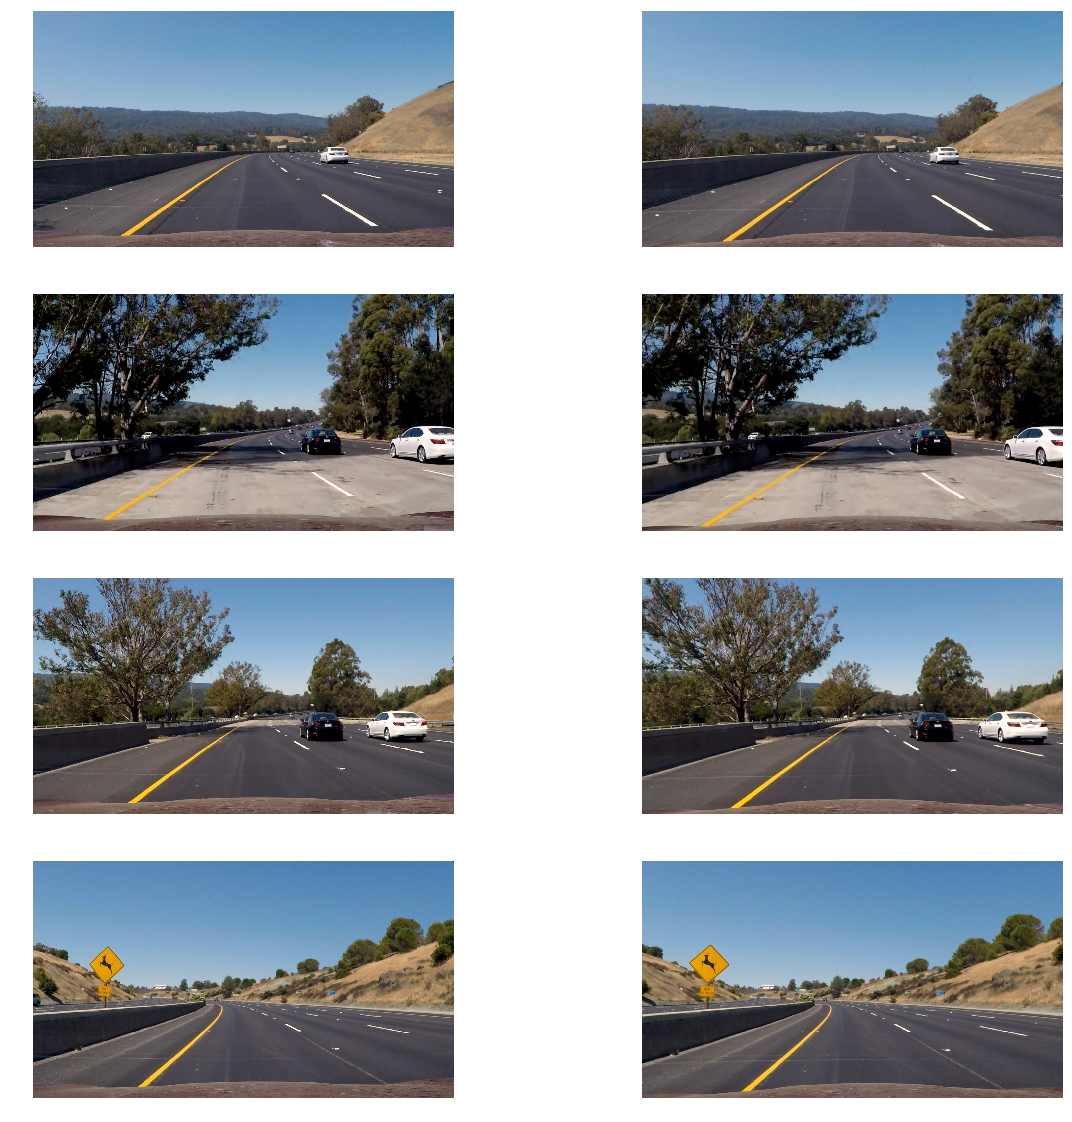

In [18]:
###########################################################################
#now we want to test this on real images
###########################################################################
resultImages = []
images = []
testImages = glob.glob("test_images/*.jpg")
for i, f in enumerate(testImages):
    img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
    images.append(img)
    img_undistorted = cv2.undistort(img, matrix, dist, None, matrix)
    resultImages.append(img_undistorted)
maxi = 4
f, axis = plt.subplots(maxi, 2, figsize=(20,20))
axis = axis.ravel()
i=0
c=0
for img in images:
    axis[c].imshow(img)
    axis[c].axis('off')
    axis[c+1].imshow(resultImages[i])
    axis[c+1].axis('off')
    c+=2
    i=i+1
    if(i>=maxi):
        break
plt.savefig('./examples/undistorted_test_image.png')

In [5]:
###########################################################################
#Use color transforms, gradients, etc., to create a thresholded binary image.
###########################################################################
def createBinaryImageRGB(img):
    threshx_min = 50
    threshx_max = 100
    threshy_min = 50
    threshy_max = 100
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    #xsobel
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    #treshold sobelx
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= threshx_min) & (scaled_sobelx <= threshx_max)] = 1
    
    #ysobel
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    #treshold sobely
    sybinary = np.zeros_like(scaled_sobely)
    sybinary[(scaled_sobely >= threshy_min) & (scaled_sobely <= threshy_max)] = 1
    
    #combination
    binImg = np.zeros_like(sxbinary)
    binImg[(sxbinary==1) & (sybinary==1)] = 1
    
    return binImg
    
def createBinaryImageHLS(img):
    s_thresh = (110, 255)
    v_thresh = (60, 255)
    
    img_hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    l_channel = img_hls[:,:,1]
    s_channel = img_hls[:,:,2]
    v_channel = img_hsv[:,:,2]
    
    # Threshold s and v channels
    sbinary = np.zeros_like(s_channel)
    sbinary[(s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    vbinary = np.zeros_like(v_channel)
    vbinary[(v_channel > v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    binImg = np.zeros_like(sbinary)
    binImg[(sbinary==1) & (vbinary==1)] = 1
    
    return binImg
    
    
def createCombinedBinaryImage(img):
    binImg1 = createBinaryImageRGB(img)
    binImg2 = createBinaryImageHLS(img)
    
    bin_combined = np.zeros_like(binImg1)
    bin_combined[(binImg1==1) | (binImg2==1)] = 1
    
    return bin_combined, binImg1, binImg2
    

Amount of Images: 8
original image, binaryImage(sobel), binaryImage(hls), ConcatenatedImage(bin1 OR bin2)


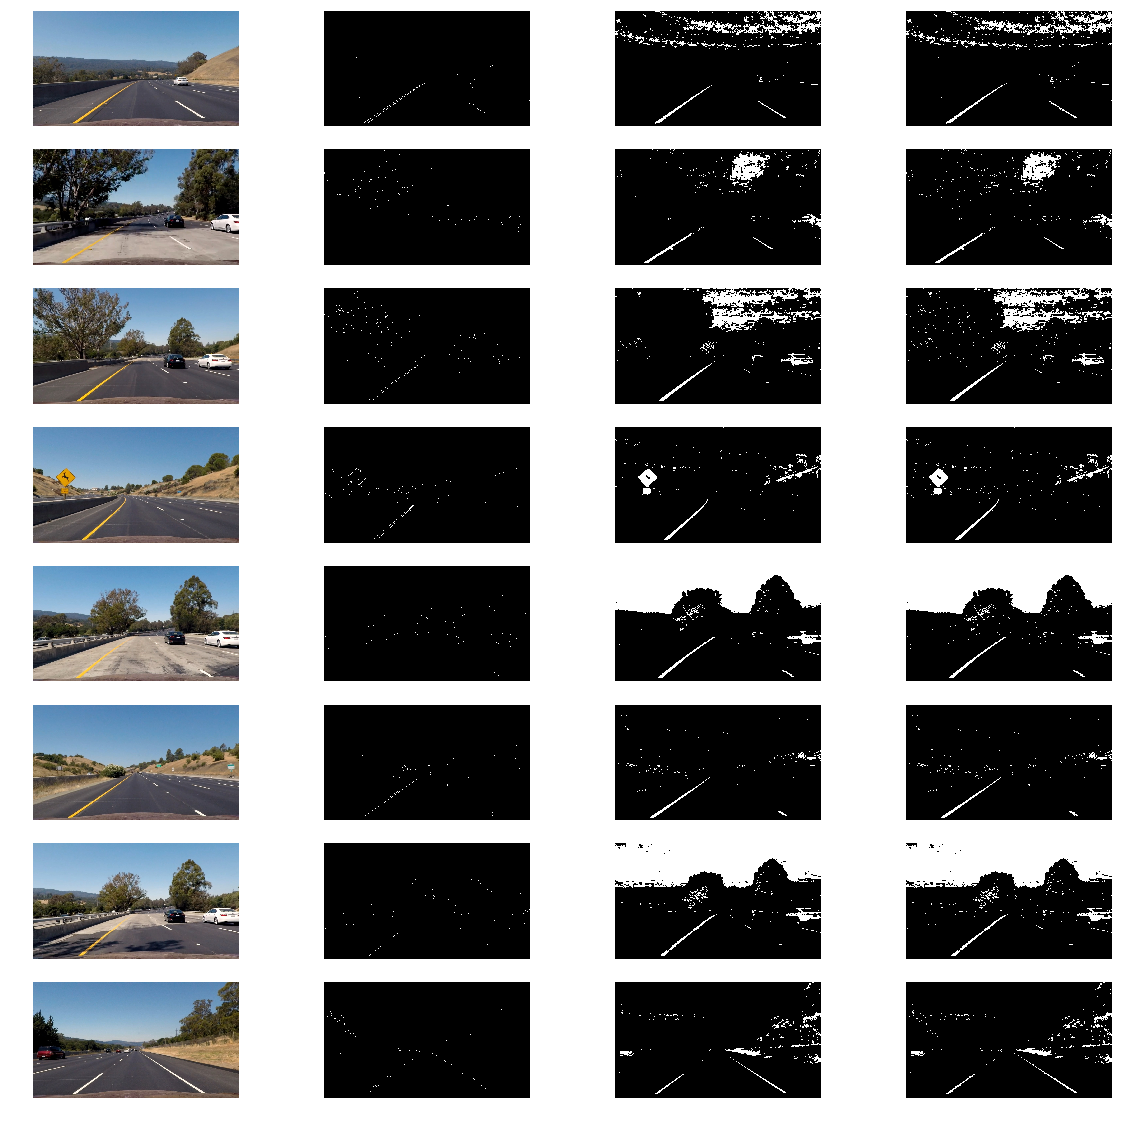

In [17]:
###########################################################################
binaryImages = []
f, axis = plt.subplots(int(len(resultImages)), 4, figsize=(20,20) )
axis = axis.ravel()
print("Amount of Images: %s" % len(resultImages))
print("original image, binaryImage(sobel), binaryImage(hls), ConcatenatedImage(bin1 OR bin2)")
c = 0
for i, img in enumerate(resultImages):
    bin_combined, binImg1, binImg2 = createCombinedBinaryImage(img)
   
    axis[c].imshow(img)
    axis[c].axis('off')
    axis[c+1].imshow(binImg1, cmap='gray')
    axis[c+1].axis('off')
    axis[c+2].imshow(binImg2, cmap='gray')
    axis[c+2].axis('off')
    axis[c+3].imshow(bin_combined, cmap='gray')
    axis[c+3].axis('off')
    c+=4
    
    binaryImages.append(bin_combined)
   
plt.savefig('./examples/binary_image.png')

In [7]:
###########################################################################
# Do Perspetive Transofrmation algorithm
###########################################################################
def warpImage(img):
    size = (img.shape[1], img.shape[0])
    #define some arbitrary points for transformation
    srcPoints = np.float32([(220,720), (570,470), (720,470), (1110,720)]) # Source points
    destPoints = np.float32([(220,720), (220,0), (1110,0), (1110,720)]) # Destination points
    #do transformation
    mat = cv2.getPerspectiveTransform(srcPoints, destPoints)
    mat_inv = cv2.getPerspectiveTransform(destPoints, srcPoints) #numpy.linalg.inv(x)
    imgWarped = cv2.warpPerspective(img, mat, size, flags=cv2.INTER_LINEAR)
    return imgWarped, mat_inv


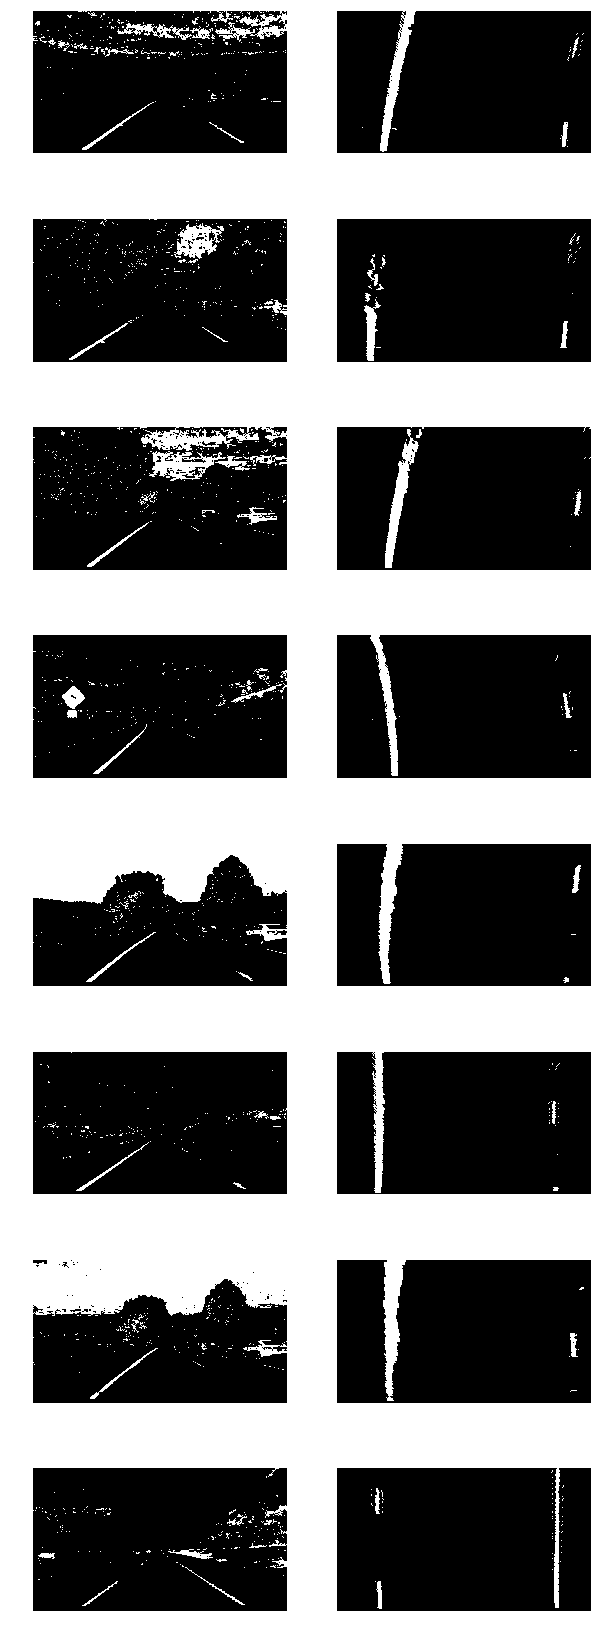

In [19]:
# lets roll
f, axis = plt.subplots(int(len(binaryImages)), 2, figsize=(10,30) )
axis = axis.ravel()
warpedImages = []
c = 0
for i, img in enumerate(binaryImages):
    #do transformation, but remember the way back (inverse)
    warpedImg, mat_inv = warpImage(img)
    
    axis[c].imshow(img, cmap='gray')
    axis[c].axis('off')
    axis[c+1].imshow(warpedImg, cmap='gray')
    axis[c+1].axis('off')
    c += 2
    
    warpedImages.append(warpedImg)
plt.savefig('./examples/binary_warping.png')
    

In [9]:
class Window:
    """A simple Holding class"""
    def __init__(self, xmin, xmax, ymin, ymax, side, pixelIds):
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.side = side # L or R
        self.pixelIds = pixelIds # idList of pixels which belong to this window 

class Lane:
    """A simple Holding class"""
    def __init__(self, fit=None, px=None, py=None, pixelsX=None, pixelsY=None, side=None):
        if(fit is None):
            self.isOk = False
            self.fit = fit
            self.side = side
            self.px = px
            self.py = py
            self.pixelsX = pixelsX
            self.pixelsY = pixelsY
            
        else:
            self.isOk = True
            self.fit = fit
            self.side = side # L or R
            self.px = px  # list of x fitted linespace
            self.py = py  # list of y fitted linespace

            self.pixelsX = pixelsX #x pixels that correspond to this fit
            self.pixelsY = pixelsY #y pixels that correspond to this fit
        
        self.offset = None          #lowest pixel offset from center
        self.curvature = None

        
class Scene:
    def __init__(self, img, lanes):
        self.img = img
        self.lanes = lanes
        
        self.offset = None #mean offset of the vehicle in the image (to offset of fitted lanes)
        

In [10]:
###########################################################################
# Do function fitting
###########################################################################
def slidingWindows(img):
     #size of the img
    size = [img.shape[0], img.shape[1]]
    #number of vertical windows
    wn = 9
    #height of vertical windows
    wh = np.int(size[0]/wn)
    #width of the windows (+- margin)
    wm = 120
    #min number of pixels in window
    wminpixels = 60
    #create output image (input + boxes)
    imgOut = np.dstack((img, img, img))*255
    ###########################################################
    # histogram of the bottom half of the image
    histogram = np.sum(img[size[0]//2:,:], axis=0)
    hSize = histogram.shape[0]
    # Find starting point of left and right boundary (peak in histogram)
    mid = np.int(hSize/2)
    lx_start = np.argmax(histogram[:mid])
    rx_start = np.argmax(histogram[mid:]) + mid
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    lx = lx_start
    rx = rx_start
    
    windows = []
    for w in range(wn):
        # Identify window boundaries in x and y (and right and left)
        ymin = size[0] - (w+1) * wh
        ymax = size[0] - w * wh
        lxmin = lx - wm
        lxmax = lx + wm
        rxmin = rx - wm
        rxmax = rx + wm
        #mark pixels inside of windows
        lidx = ((nonzeroy >= ymin) & (nonzeroy < ymax) & 
            (nonzerox >= lxmin) &  (nonzerox < lxmax)).nonzero()[0]
        ridx = ((nonzeroy >= ymin) & (nonzeroy < ymax) & 
            (nonzerox >= rxmin) &  (nonzerox < rxmax)).nonzero()[0]
        #recenter windows
        if len(lidx) > wminpixels:
            lx = np.int(np.mean(nonzerox[lidx]))
        if len(ridx) > wminpixels:        
            rx = np.int(np.mean(nonzerox[ridx]))
        #visualize window
        cv2.rectangle(imgOut, (lxmin,ymin), (lxmax,ymax), (0,255,0), 5) 
        cv2.rectangle(imgOut, (rxmin,ymin), (rxmax,ymax),(0,255,0), 5)
        #remember windows
        windows.append(Window(lxmin, lxmax, ymin, ymax, "L", lidx))
        windows.append(Window(rxmin, rxmax, ymin, ymax, "R", ridx))
    return windows, histogram, imgOut


In [11]:
def fitWindows(windows, img):
    size = [img.shape[0], img.shape[1]]
    lanes = []
    imgOut = np.zeros((size[0],size[1],3), np.uint8)
    
    #grab all nonzero pixels in image
    nonzero = img.nonzero()
    pixelsLeft = []
    pixelsRight = []
    for w in windows:
        if(w.side == "L"):
            pixelsLeft.append(w.pixelIds)
        else:
            pixelsRight.append(w.pixelIds)
    #make a structured single List of pixel Idx
    pixelsLeft = np.concatenate(pixelsLeft)
    pixelsRight = np.concatenate(pixelsRight)
    #grab all pixels of these pixelIdx
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    pixelsLeftx = nonzerox[pixelsLeft]
    pixelsLefty = nonzeroy[pixelsLeft] 
    pixelsRightx = nonzerox[pixelsRight]
    pixelsRighty = nonzeroy[pixelsRight] 
    
     # fit polynomial through pixels (n=2)
    fitL = np.polyfit(pixelsLefty, pixelsLeftx, 2)
    fitR = np.polyfit(pixelsRighty, pixelsRightx, 2)
    
    # plot the fitted lane by calculating pixels of polynomial
    py = np.linspace(0, size[0]-1, size[0])
    plx = fitL[0] * py**2 + fitL[1] * py + fitL[2]
    prx = fitR[0] * py**2 + fitR[1] * py + fitR[2]
    
    lanes.append(Lane(fitL, plx, py, pixelsLeftx, pixelsLefty, "L"))
    lanes.append(Lane(fitR, prx, py, pixelsRightx, pixelsRighty,"R"))

    #py = py.astype(int)
    #plx = plx.astype(int)
    #prx = prx.astype(int)
    
    #for i in range(0, len(py)-3, 3):
    #    cv2.line(imgOut, (plx[i], py[i]),(plx[i+3], py[i+3]),(255,0,0),5)
    #    cv2.line(imgOut, (prx[i], py[i]),(prx[i+3], py[i+3]),(255,0,0),5)
        
    #draw output image red for L and R
    #imgOut[py, plx] = [255, 0, 0]
    #imgOut[py, prx] = [255, 0, 0]

    return lanes, imgOut

Amount of warped Images: 8 


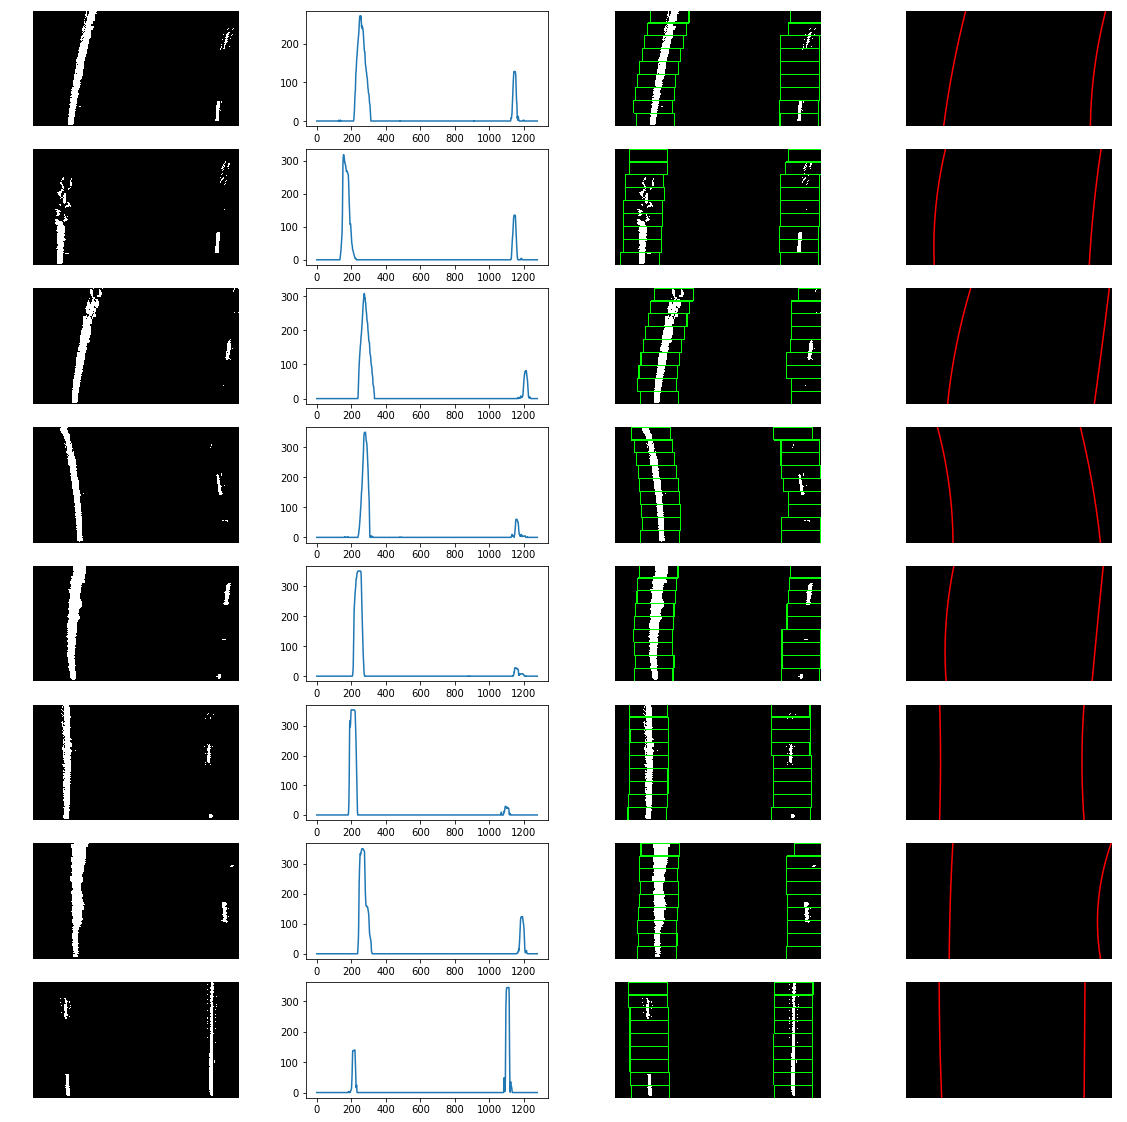

In [20]:
#lets roll
print("Amount of warped Images: %s " % len(warpedImages))
f, axis = plt.subplots(int(len(warpedImages)), 4, figsize=(20,20) )
axis = axis.ravel()

sceneList = []
c = 0
for i, img in enumerate(warpedImages):
    windows, hist, boxImg = slidingWindows(img)
    lanes, fitImg = fitWindows(windows, img)
    
    axis[c].imshow(img, cmap='gray')
    axis[c].axis('off')
    axis[c+1].plot(hist)
    axis[c+1].axis('on')
    axis[c+2].imshow(boxImg, cmap='gray')
    axis[c+2].axis('off')
    axis[c+3].imshow(fitImg, cmap='gray')
    axis[c+3].plot(lanes[0].px, lanes[0].py, color="red")
    axis[c+3].plot(lanes[1].px, lanes[1].py, color="red")
    axis[c+3].axis('off')
    c += 4
    
    sceneList.append(Scene(img, lanes))

plt.savefig('./examples/lane_fitting.png')

In [13]:
###########################################################################
# Determine the curvature of the lane 
###########################################################################
def calculateCurvature(lane):
    # Define conversions in x and y from pixels space to meters
    ympp = 30 / 720        # meters per pixel in y dimension 
    xmpp = 3.7 / 900       # meters per pixel in x dimension
    
    yEval = np.max(lane.py)

    # Fit new polynomials to x,y in world space
    fitCircle  = np.polyfit(lane.pixelsY * ympp, lane.pixelsX * xmpp, 2)
    #print(fitCircle)
    # Calculate the new radii of curvature
    curveRadius = ((1 + (2 * fitCircle[0] * yEval * ympp + fitCircle[1])**2)**1.5) / np.absolute(2 * fitCircle[0]) 
    return curveRadius

for i, s in enumerate(sceneList):
    print("Scene: ")
    for l in s.lanes:
        c = calculateCurvature(l)
        print("[%s] curvature: %s" % (l.side, c))
        l.curvature = c

Scene: 
[L] curvature: 2443.48113266
[R] curvature: 1243.42000068
Scene: 
[L] curvature: 1100.92619456
[R] curvature: 3210.45272339
Scene: 
[L] curvature: 1514.65553283
[R] curvature: 18476.2296601
Scene: 
[L] curvature: 1161.12323514
[R] curvature: 2211.06272245
Scene: 
[L] curvature: 1097.53599721
[R] curvature: 25638.3481333
Scene: 
[L] curvature: 4581.70002151
[R] curvature: 2121.39116262
Scene: 
[L] curvature: 5562.98650158
[R] curvature: 591.279855195
Scene: 
[L] curvature: 7570.16810149
[R] curvature: 354093.286588


In [14]:
###########################################################################
# Determine vehicle position with respect to center
###########################################################################
def centerOffsetLanes(img, ll, rr):
    xmpp = 3.7/900
    size = [img.shape[0], img.shape[1]]
    #calculate middle of image (car center)
    carPosition = size[1] / 2
    #try using the fitte functins to 
    
    ll.offset = ll.fit[0] * size[0]**2 + ll.fit[1] * size[0] + ll.fit[2]
    rr.offset = rr.fit[0] * size[0]**2 + rr.fit[1] * size[0] + rr.fit[2]
    
    #calculate mean offset
    laneCenter = (ll.offset + rr.offset) / 2
    
    #calculate diff of mean to car position
    centerOffset = (carPosition - laneCenter) * xmpp
    return centerOffset

def centerOffset(s):
    xmpp = 3.7/900
    size = [img.shape[0], img.shape[1]]
    #calculate middle of image (car center)
    carPosition = size[1] / 2
    #try using the fitte functins to 
    
    offsets = []
    for i, lane in enumerate(s.lanes):
        lane.offset = lane.fit[0] * size[0]**2 + lane.fit[1] * size[0] + lane.fit[2]
    
    #calculate mean offset
    laneCenter = 0
    for l in s.lanes:
        laneCenter += l.offset
    laneCenter = laneCenter / len(lanes)
    
    #calculate diff of mean to car position
    centerOffset = (carPosition - laneCenter) * xmpp
    return centerOffset

#lets go
for i, s in enumerate(sceneList):
    s.offset = centerOffset(s)
    print("[%s] Scene Center Offset: %s" % (i, s.offset))

[0] Scene Center Offset: -0.196465018717
[1] Scene Center Offset: -0.0610572725521
[2] Scene Center Offset: -0.297736554872
[3] Scene Center Offset: -0.444561023384
[4] Scene Center Offset: -0.249928181327
[5] Scene Center Offset: -0.0626727906737
[6] Scene Center Offset: -0.397922506056
[7] Scene Center Offset: -0.0911673871282


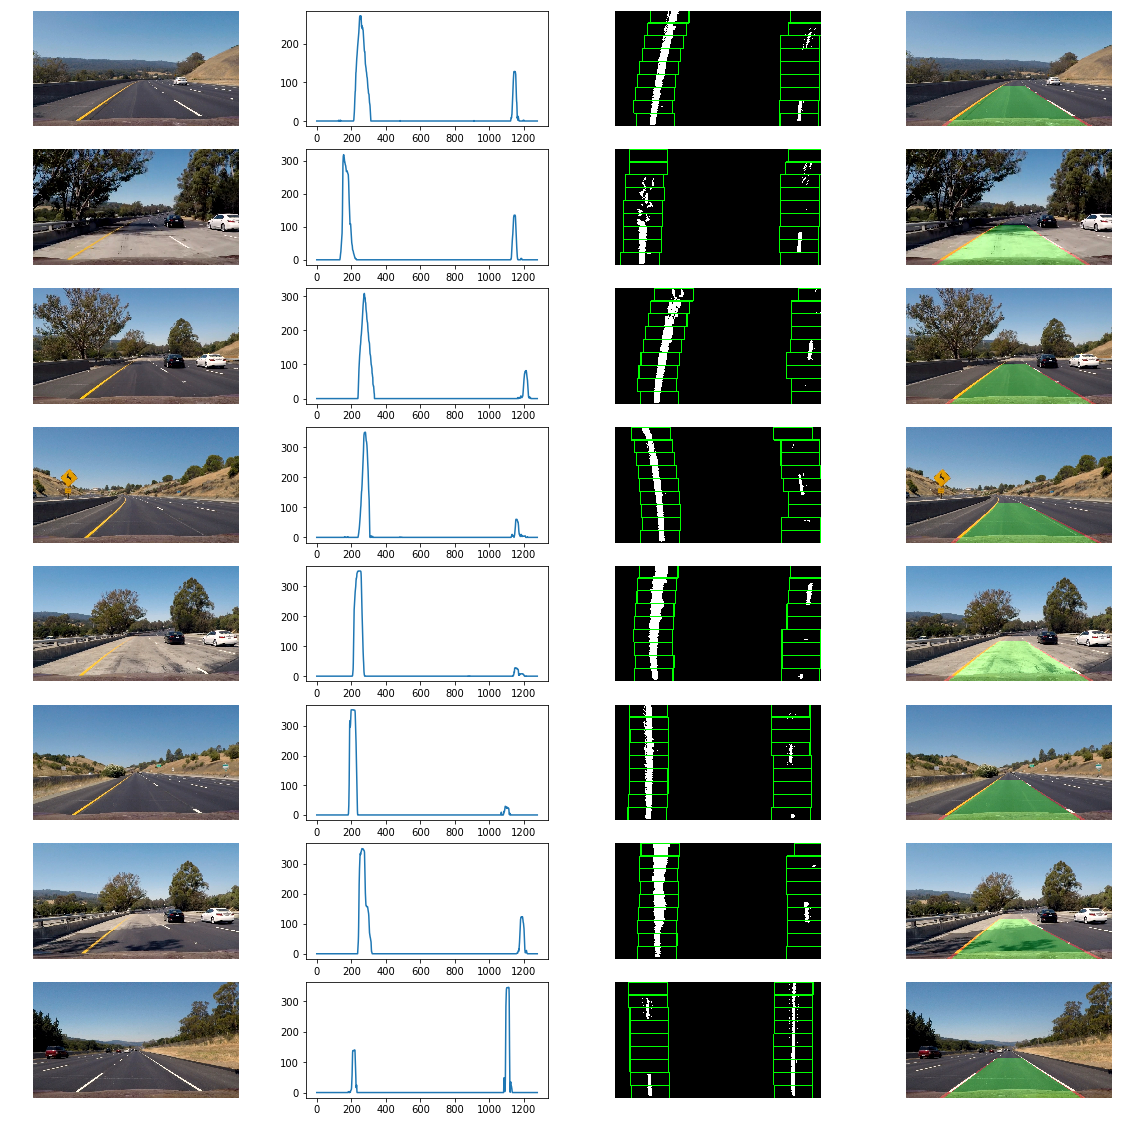

In [22]:
###########################################################################
# example images and pipeline for drawing the lane onto the real image
###########################################################################
def pipeline(img):
    undistImg = cv2.undistort(img, matrix, dist, None, matrix)
    binaryImg, bin1, bin2 = createCombinedBinaryImage(undistImg)
    binaryWarpedImg, matInv = warpImage(binaryImg)
    
    windows, hist, boxImg = slidingWindows(binaryWarpedImg)
    lanes, fitImg = fitWindows(windows, binaryWarpedImg)
    warpinator = np.zeros_like(binaryWarpedImg).astype(np.uint8)
    coloredWarp = np.dstack((warpinator, warpinator, warpinator))
    
    #print(len(lanes))warpinator
    # Recast the x and y points into usable format for cv2.fillPoly()
    pointList = []
    for l in lanes:
        if(l.side == "L"):
            ps = np.array([np.transpose(np.vstack([l.px, l.py]))])
        else:
            ps = np.array([np.flipud(np.transpose(np.vstack([l.px, l.py])))])
        pointList.append(ps)
        
    pts = np.hstack(pointList)

    # Draw the lane onto the warped blank image
    cv2.fillPoly(coloredWarp, np.int_([pts]), (0,255, 0))
    for pl in pointList:
        cv2.polylines(coloredWarp, np.int32([pl]), isClosed=False, color=(255,0,0), thickness=30)

    inverseWarp = cv2.warpPerspective(coloredWarp, matInv, (binaryWarpedImg.shape[1], binaryWarpedImg.shape[0]))
    resultImg = cv2.addWeighted(img, 1, inverseWarp, 0.3, 0)
    return resultImg, hist, boxImg


    
#use testImages list for real images
f, axis = plt.subplots(int(len(warpedImages)), 4, figsize=(20,20) )
axis = axis.ravel()
c = 0
laneImages = []
for i, f in enumerate(testImages):
    img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
    newImg, hist, debug = pipeline(img)
    laneImages.append(newImg)
    #Visualize
    axis[c].imshow(img)
    axis[c].axis('off')
    axis[c+1].plot(hist)
    axis[c+1].axis('on')
    axis[c+2].imshow(debug)
    axis[c+2].axis('off')
    axis[c+3].imshow(newImg)
    axis[c+3].axis('off')
    c += 4
plt.savefig('./examples/lineArea1.png')


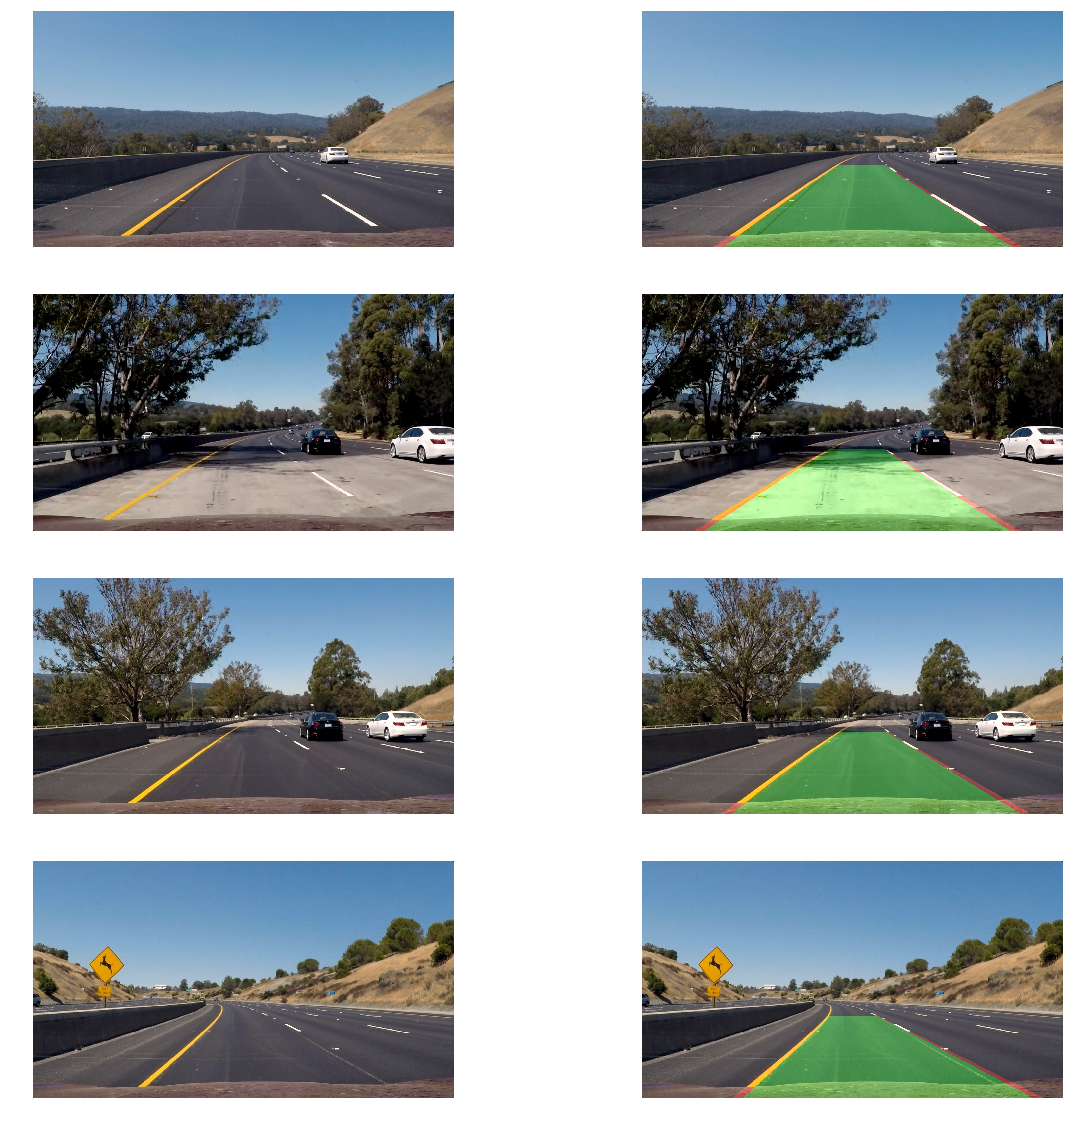

In [23]:

maxi = 4
f, axis = plt.subplots(maxi, 2, figsize=(20,20))
axis = axis.ravel()
i=0
c=0
for i, f in enumerate(testImages):
    img = cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB)
    newImg, hist, debug = pipeline(img)
    axis[c].imshow(img)
    axis[c].axis('off')
    axis[c+1].imshow(newImg)
    axis[c+1].axis('off')
    c+=2
    i=i+1
    if(i>=maxi):
        break
plt.savefig('./examples/lineArea2.png')

In [16]:
###########################################################################
# video pipeline
###########################################################################
def processVideo(img):
    global laneL
    global laneR
    
    lanes = []
    
    undistImg = cv2.undistort(img, matrix, dist, None, matrix)
    binaryImg, bin1, bin2 = createCombinedBinaryImage(undistImg)
    binaryWarpedImg, matInv = warpImage(binaryImg)
    
    if not laneL.isOk or not laneR.isOk:
        windows, hist, boxImg = slidingWindows(binaryWarpedImg)
        lanes, fitImg = fitWindows(windows, binaryWarpedImg)
    else:
        pass
        #left_fit, right_fit, left_fitx, right_fitx, left_line_pts, right_line_pts, out_img, ploty, left_lane_inds, right_lane_inds = fit_from_previous_frame(warped_img, l_line.best_fit, r_line.best_fit)
    
    #reset lane vars
    for lane in lanes:
        if lane.side == "L":
            laneL = lane
        else:
            laneR = lane

    allFine = False
    if(laneL is None or laneR is None):
        print("lane detection failed")
    else:
        laneL.isOk = True
        laneR.isOk = True
        allFine = True
        
    if(allFine):
        warpinator = np.zeros_like(binaryWarpedImg).astype(np.uint8)
        coloredWarp = np.dstack((warpinator, warpinator, warpinator))
        
        psl = np.array([np.transpose(np.vstack([laneL.px, laneL.py]))])
        psr = np.array([np.flipud(np.transpose(np.vstack([laneR.px, laneR.py])))])
        pts = np.hstack((psl, psr))
        
        cv2.fillPoly(coloredWarp, np.int_([pts]), (0,255, 0))
        cv2.polylines(coloredWarp, np.int32([psl]), isClosed=False, color=(255,0,0), thickness=30)
        cv2.polylines(coloredWarp, np.int32([psr]), isClosed=False, color=(255,0,0), thickness=30)

        inverseWarp = cv2.warpPerspective(coloredWarp, matInv, (binaryWarpedImg.shape[1], binaryWarpedImg.shape[0]))
        resultImg = cv2.addWeighted(img, 1, inverseWarp, 0.3, 0)
        
        laneL.curvature = calculateCurvature(laneL)
        laneR.curvature = calculateCurvature(laneR)
        mean_curve = (laneL.curvature + laneR.curvature) / 2
        offset = centerOffsetLanes(binaryWarpedImg, laneL, laneR)
        #print(offset)
        
        #https://docs.opencv.org/3.1.0/dc/da5/tutorial_py_drawing_functions.html
        cv2.putText(resultImg, "Curve Radius: "  + str(mean_curve)[:6]  + "m",(20,50),  cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        cv2.putText(resultImg, "Center Offset: " + str(offset)[:6]     + "m" ,(20,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)

    
    # History
    # ...
    
    #set our lanes to Not Ok, so that we will refit our things
    laneL.isOk = False
    laneR.isOk = False
    
    return resultImg


#lets go 
global laneL
global laneR

laneL = Lane()
laneR = Lane()


#normal video
project_video_output = "project_video_output.mp4"
project_video_input = VideoFileClip("project_video.mp4")

#process clipped 
#clip = project_video_input.subclip(0,5)
#processed_project_video = clip.fl_image(processVideo)
#%time processed_project_video.write_videofile(project_video_output, audio=False)

#process all
processed_project_video = project_video_input.fl_image(processVideo)
%time processed_project_video.write_videofile(project_video_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [03:57<00:00,  5.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 8min 51s, sys: 11.7 s, total: 9min 3s
Wall time: 3min 58s
